Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.preprocessing import normalize
from scipy.special import expit as sigmoid
import sklearn.metrics as metrics

Data loading and preprocessing

In [3]:
csv_path = "/home/jens/masterRepo/test/dataset/analysis_of_tp_and_fp_5.000000_5.000000.csv"
df = pd.read_csv(csv_path, dtype = {"objName":"category"})
df["visibleInlierFrac"] = df["visibleInliers"]/df["visiblePoints"]
df["visiblePointsFrac"] = df["visiblePoints"]/df["objectPoints"]
df["penetration"] = df[["penetrationInternal","penetrationExternal"]].max(axis=1)
df["intersectingInliers"] = df[["intersectingInliersInternal","intersectingInliersExternal"]].max(axis=1)
df["inCollision"] = df[["inCollisionInternal","inCollisionExternal"]].max(axis=1)
df["intersectingInliersFrac"] = df["intersectingInliers"] / df["visibleInliers"]
df["intersectingInliersInternalFrac"] = df["intersectingInliersInternal"] / df["visibleInliers"]
df["intersectingInliersExternalFrac"] = df["intersectingInliersExternal"] / df["visibleInliers"]
df[["visibleInlierFrac","visiblePointsFrac","penetration","intersectingInliers","inCollision","intersectingInliersFrac","intersectingInliersInternalFrac","intersectingInliersExternalFrac"]]=df[["visibleInlierFrac","visiblePointsFrac","penetration","intersectingInliers","inCollision","intersectingInliersFrac","intersectingInliersInternalFrac","intersectingInliersExternalFrac"]].fillna(0)


df.head()

,objName,dpI,gI,g,score,visiblePoints,visibleInliers,inCollisionInternal,inCollisionExternal,penetrationInternal,...,intersectingInliersExternal,objectPoints,visibleInlierFrac,visiblePointsFrac,penetration,intersectingInliers,inCollision,intersectingInliersFrac,intersectingInliersInternalFrac,intersectingInliersExternalFrac
0,AngleTubes,0,0,1,56.9764,1668,1317,0,0,0.0,...,0,5051,0.789568,0.330232,0.000000,0,0,0.000000,0.000000,0.0
1,AngleTubes,0,1,1,55.1934,1728,1256,1,0,0.0,...,0,5051,0.726852,0.342110,0.125520,1,1,0.000796,0.000796,0.0
2,AngleTubes,0,2,1,53.7115,1754,1220,0,0,0.0,...,0,5051,0.695553,0.347258,0.000000,0,0,0.000000,0.000000,0.0
3,AngleTubes,0,3,1,51.1050,1769,1275,1,0,0.0,...,0,5051,0.720746,0.350228,0.572053,0,1,0.000000,0.000000,0.0
4,AngleTubes,0,4,1,49.9980,1601,1177,1,0,0.0,...,0,5051,0.735166,0.316967,0.661725,0,1,0.000000,0.000000,0.0


In [4]:
df.groupby(["objName","g"]).mean()[["score","inCollision","inCollisionInternal","intersectingInliers","intersectingInliersInternal"]]


score  inCollision  inCollisionInternal  \
objName    g                                                
AngleTubes 0  29.128259     0.597156             0.289100   
           1  39.806362     0.527221             0.363897   
Conrods    0  15.842540     0.886275             0.749020   
           1  26.514218     0.684444             0.386667   
Ears       0  13.935260     0.679803             0.586207   
           1  20.116707     0.436620             0.098592   
Gameboys   0  23.160628     0.699187             0.585366   
           1  40.203082     0.455882             0.058824   

              intersectingInliers  intersectingInliersInternal  
objName    g                                                    
AngleTubes 0            16.663507                     5.729858  
           1             6.905444                     0.057307  
Conrods    0            22.756863                    11.274510  
           1            14.373333                     0.057778  
Ears       0            67.527094                    62.591133  
           1            16.042254                     0.549296  
Gameboys   0           101.186992                    83.943089  
           1            38.514706                     0.411765

In [33]:

def makeList(obj):
    if type(obj) is not list:
        obj = [obj]
    return obj
def get_data_for_logistic_regression(df,objects,factors,normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    obj_df = df[df["objName"].isin(objects)]
    X = obj_df[factors].values
    if len(X.shape)==1:
        X = np.expand_dims(X,axis=1)
    if normalize_factors:
        X = normalize(X,axis=0,norm="max")

    y = np.expand_dims(obj_df.g.values,axis=1)

    return X, y

def binary_logistic_regession_individual_factors(df,objects = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"factor":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for obj in objects:
        for factor in factors:
            X,y = get_data_for_logistic_regression(df,obj,factor,normalize_factors)
            model = LogisticRegressionCV(solver='L-BFGS', random_state=42).fit(X, y)
            models[obj+":"+factor] = model
            classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
            result_dict["objName"].append(obj)
            result_dict["factor"].append(factor)
            result_dict["accuracy"].append(classification_report["accuracy"])
            result_dict["precision"].append(classification_report["1"]["precision"])
            result_dict["recall"].append(classification_report["1"]["recall"])
            result_dict["f1"].append(classification_report["1"]["f1-score"])
            result_dict["n_posetives"].append(classification_report["1"]["support"])
            result_dict["n_negatives"].append(classification_report["0"]["support"])
    
    result_df = pd.DataFrame(result_dict)

    return models, result_df

def binary_logistic_regession(df,objects = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    objects = makeList(objects)
    factors = makeList(factors)
    models = {}
    result_dict = {"objName":[],"accuracy":[],"precision":[],"recall":[],"f1":[],"n_posetives":[],"n_negatives":[]}
    for factor in factors:
        result_dict[factor+"_w"]=[]
    result_dict["intercept"]=[]

    for obj in objects:
        X,y = get_data_for_logistic_regression(df,obj,factors,normalize_factors)
        model = LogisticRegressionCV(solver='L-BFGS', random_state=42).fit(X, y)
        models[obj] = model
        classification_report = metrics.classification_report(y,model.predict(X),output_dict=True)
        result_dict["objName"].append(obj)
        result_dict["accuracy"].append(classification_report["accuracy"])
        result_dict["precision"].append(classification_report["1"]["precision"])
        result_dict["recall"].append(classification_report["1"]["recall"])
        result_dict["f1"].append(classification_report["1"]["f1-score"])
        result_dict["n_posetives"].append(classification_report["1"]["support"])
        result_dict["n_negatives"].append(classification_report["0"]["support"])
        for factor,coef in zip(factors,model.coef_[0]):
            result_dict[factor+"_w"].append(coef)
        result_dict["intercept"].append(model.intercept_[0])

    result_df = pd.DataFrame(result_dict)

    return models, result_df



def logistic_regression_plots_individual_factors(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac"],normalize_factors=True):
    n_objects = len(object_names)
    n_factors = len(factors)
    models = {}
    fig, axes = plt.subplots(n_factors,n_objects,figsize=(n_objects*5,n_factors*5))
    for ax_row,factor in zip(axes,factors):
        for ax, obj in zip(ax_row,object_names):
            obj_df = df[df["objName"]==obj]
            X = np.expand_dims(obj_df[factor].values,axis=1)
            if(normalize_factors):
                X = normalize(X,axis=0,norm="max")

            y = np.expand_dims(obj_df.g.values,axis=1)
            model = LogisticRegressionCV(solver='L-BFGS', random_state=42).fit(X, y)
            models[obj+":"+factor] = model
            y_pred = model.predict(X)

            cm =  metrics.confusion_matrix(y,y_pred)
            X_transformed = X.dot(model.coef_.T) + model.intercept_

            sigmoid_x = np.linspace(np.min(X_transformed,axis=0), np.max(X_transformed,axis=0), 500)
            sigmoid_y = sigmoid(sigmoid_x).ravel()
            ax.plot(sigmoid_x, sigmoid_y.ravel(), color='red', linewidth=3)
            ax.scatter(X_transformed, y,c=y,cmap=mpl.colors.ListedColormap(["C0","C1"]),alpha=0.1,edgecolors=None,marker='s')

            ax.axvline(x=0, ymin=0, ymax=1,ls='--',alpha=0.75,color="C2")
            ax.set_ylabel("$\sigma$")
            ax.set_xlabel(factor)
            ax.set_title("{0}, Acc {1:.3f} F1 {2:.3f}".format(obj,metrics.accuracy_score(y,y_pred),metrics.f1_score(y,y_pred)))

    return fig,axes

def logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["scoreFrac","visibleInlierFrac","visiblePointsFrac","penetrationInternal","intersectingInliersFrac"],normalize_factors=True):
    n_objects = len(object_names)
    n_factors = len(factors)
    fig, axes = plt.subplots(1,n_objects,figsize=(n_objects*5,5))
    fig.suptitle("Linear Combination of: {}".format(factors), fontsize=16)
    for ax, obj in zip(axes,object_names):
        obj_df = df[df["objName"]==obj]
        X = obj_df[factors].values
        if(normalize_factors):
            X = normalize(X,axis=0,norm="max")

        y = np.expand_dims(obj_df.g.values,axis=1)
        model = LogisticRegressionCV(solver='L-BFGS', random_state=0).fit(X, y)
        y_pred = model.predict(X)

        cm =  metrics.confusion_matrix(y,y_pred)
        X_transformed = X.dot(model.coef_.T) + model.intercept_

        sigmoid_x = np.linspace(np.min(X_transformed,axis=0), np.max(X_transformed,axis=0), 500)
        sigmoid_y = sigmoid(sigmoid_x).ravel()
        ax.plot(sigmoid_x, sigmoid_y, color='red', linewidth=3)
        ax.scatter(X_transformed, y,c=y,cmap=mpl.colors.ListedColormap(["C0","C1"]),alpha=0.1,edgecolors=None,marker='s')

        ax.axvline(x=0, ymin=0, ymax=1,ls='--',alpha=0.75,color="C2")
        ax.set_ylabel("$\sigma$")
        # ax.legend(["Decision Function","Decision threshold"])
        ax.set_title("{0}, Acc {1:.3f} F1 {2:.3f}".format(obj,metrics.accuracy_score(y,y_pred),metrics.f1_score(y,y_pred)))

    return fig,axes

def print_tuning_params(result_df,variables):
    for index,row in result_df.iterrows():
        for v in variables:
            print(row["objName"],"LR",v+"_w",row[v+"_w"],sep=",")
        print(row["objName"],"LR","intercept",row["intercept"],sep=",")     

## Logistic Regression on Individual Pr Object factors

In [34]:
variables = ["score","visibleInlierFrac","visiblePointsFrac"]
models, result_df = binary_logistic_regession_individual_factors(df,["AngleTubes","Ears","Conrods","Gameboys"],variables,normalize_factors=False)
result_df.head()

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/ma

,objName,factor,accuracy,precision,recall,f1,n_posetives,n_negatives
0,AngleTubes,score,0.733929,0.747525,0.865330,0.802125,349,211
1,AngleTubes,visibleInlierFrac,0.732143,0.746898,0.862464,0.800532,349,211
2,AngleTubes,visiblePointsFrac,0.707143,0.703297,0.916905,0.796020,349,211
3,Ears,score,0.777372,0.692308,0.253521,0.371134,71,203
4,Ears,visibleInlierFrac,0.817518,0.684211,0.549296,0.609375,71,203


/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/ma

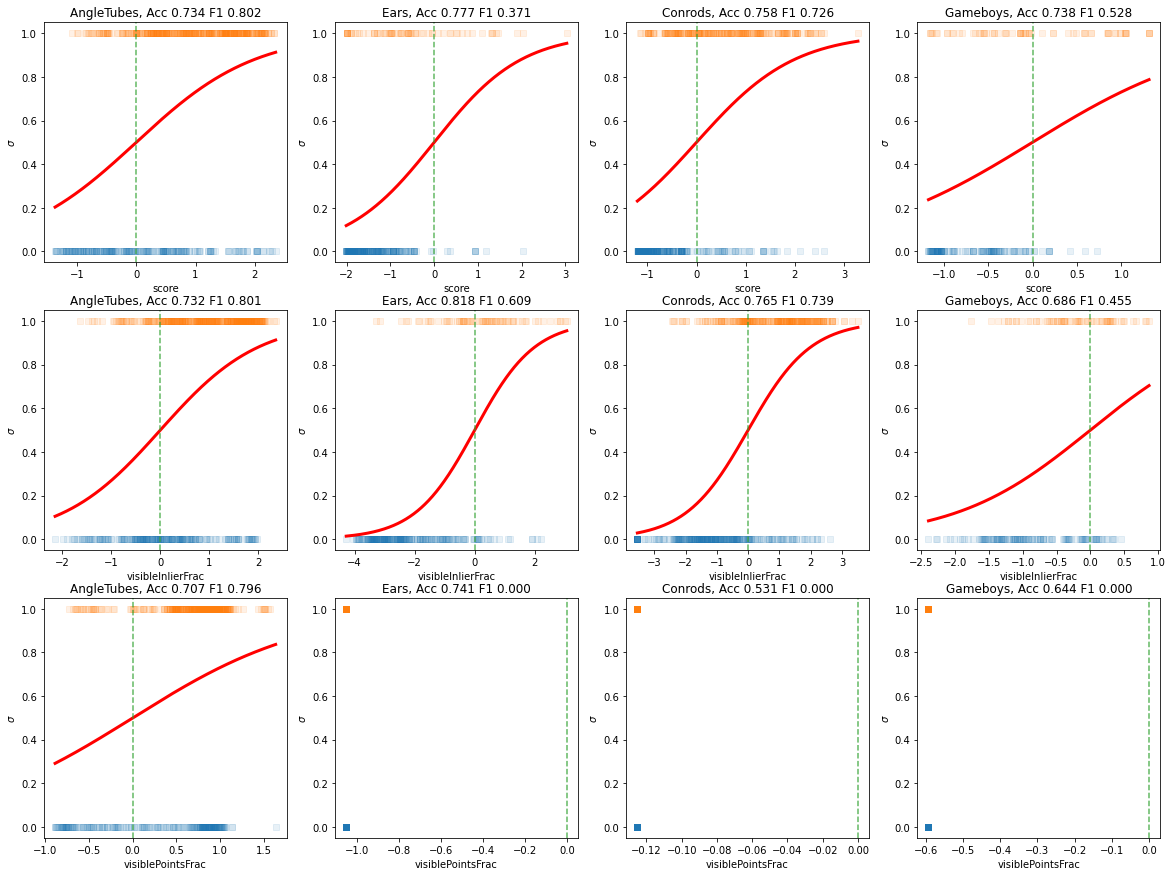

In [35]:
logistic_regression_plots_individual_factors(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["score","visibleInlierFrac","visiblePointsFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegressionIndividual.pdf")
plt.savefig("PrObjectLogisticRegressionIndividual.png")
plt.show()

## Logistic Regression on Linear combination of Pr Object factors

In [36]:
models, result_df = binary_logistic_regession(df,["AngleTubes","Ears","Conrods","Gameboys"],["score","visiblePointsFrac","visibleInlierFrac"],normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/ma

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,intercept
0,AngleTubes,0.730357,0.743842,0.865330,0.800000,349,211,0.071406,0.131916,0.348374,-2.181732
1,Ears,0.795620,0.714286,0.352113,0.471698,71,203,0.070268,2.141581,2.554021,-4.242063
2,Conrods,0.758333,0.773869,0.684444,0.726415,225,255,0.108123,-0.002122,0.004862,-2.291593
3,Gameboys,0.738220,0.736842,0.411765,0.528302,68,123,0.040086,-0.031022,-0.010101,-1.558921


In [37]:
print_tuning_params(result_df,variables)

AngleTubes,LR,score_w,0.07140646395405183
AngleTubes,LR,visibleInlierFrac_w,0.34837355514174695
AngleTubes,LR,visiblePointsFrac_w,0.1319162781855579
AngleTubes,LR,intercept,-2.181732461511058
Ears,LR,score_w,0.07026812477440403
Ears,LR,visibleInlierFrac_w,2.5540210608470124
Ears,LR,visiblePointsFrac_w,2.141581171941151
Ears,LR,intercept,-4.242063483849274
Conrods,LR,score_w,0.10812341163138452
Conrods,LR,visibleInlierFrac_w,0.0048619432020427155
Conrods,LR,visiblePointsFrac_w,-0.0021224409659404996
Conrods,LR,intercept,-2.291593289576625
Gameboys,LR,score_w,0.04008584899707572
Gameboys,LR,visibleInlierFrac_w,-0.010101150335570451
Gameboys,LR,visiblePointsFrac_w,-0.031022412872109145
Gameboys,LR,intercept,-1.5589210423084305


/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/ma

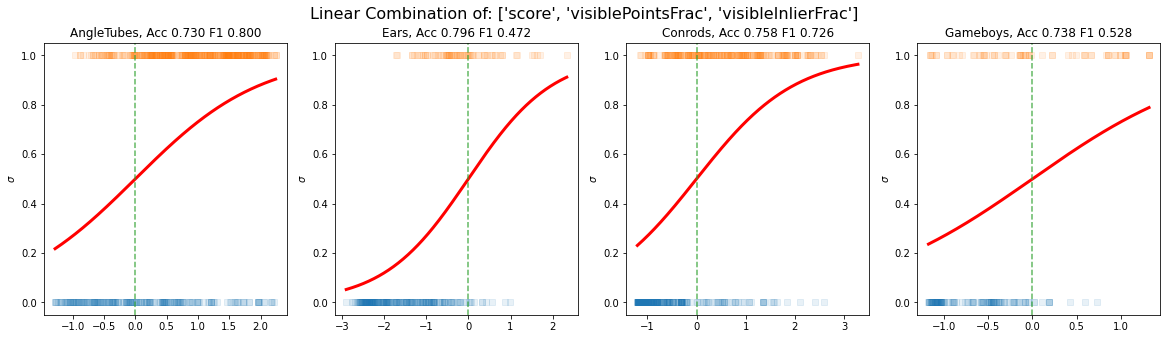

In [38]:
logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= ["score","visiblePointsFrac","visibleInlierFrac"],normalize_factors=False)
plt.savefig("PrObjectLogisticRegression.pdf")
plt.savefig("PrObjectLogisticRegression.png")
plt.show()

## Logistic Regression on Linear combination of Pr Object factors and Global factors

In [39]:
variables = ["score","visiblePointsFrac","visibleInlierFrac","intersectingInliersFrac"]
models, result_df = binary_logistic_regession(df,["AngleTubes","Ears","Conrods","Gameboys"],variables,normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/ma

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,intersectingInliersFrac_w,intercept
0,AngleTubes,0.730357,0.743842,0.865330,0.800000,349,211,0.071364,0.132826,0.348458,-0.173569,-2.178755
1,Ears,0.835766,0.842105,0.450704,0.587156,71,203,0.075549,2.158189,2.516971,-2.379144,-4.141621
2,Conrods,0.772917,0.784314,0.711111,0.745921,225,255,0.132828,-0.275758,1.829622,-1.512584,-3.214610
3,Gameboys,0.753927,0.756098,0.455882,0.568807,68,123,0.065446,-0.454349,-0.035904,-0.504075,-2.222592


In [40]:
result_df[[s+"_w" for s in variables]+["intercept"]].mean()

score_w                      0.086297
visiblePointsFrac_w          0.390227
visibleInlierFrac_w          1.164787
intersectingInliersFrac_w   -1.142343
intercept                   -2.939394
dtype: float64

In [41]:
print_tuning_params(result_df,variables)

AngleTubes,LR,score_w,0.07136429961893076
AngleTubes,LR,visiblePointsFrac_w,0.13282630396347853
AngleTubes,LR,visibleInlierFrac_w,0.3484581483257868
AngleTubes,LR,intersectingInliersFrac_w,-0.17356882728577097
AngleTubes,LR,intercept,-2.1787550650602077
Ears,LR,score_w,0.07554913862643778
Ears,LR,visiblePointsFrac_w,2.158189280385255
Ears,LR,visibleInlierFrac_w,2.5169711814969933
Ears,LR,intersectingInliersFrac_w,-2.379143867318198
Ears,LR,intercept,-4.141620888208712
Conrods,LR,score_w,0.1328276903890317
Conrods,LR,visiblePointsFrac_w,-0.2757584917836477
Conrods,LR,visibleInlierFrac_w,1.8296219611872757
Conrods,LR,intersectingInliersFrac_w,-1.5125837685223684
Conrods,LR,intercept,-3.214609971935381
Gameboys,LR,score_w,0.06544576449828289
Gameboys,LR,visiblePointsFrac_w,-0.4543488132113888
Gameboys,LR,visibleInlierFrac_w,-0.035903572322981
Gameboys,LR,intersectingInliersFrac_w,-0.5040754092572395
Gameboys,LR,intercept,-2.222591679959404


/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/ma

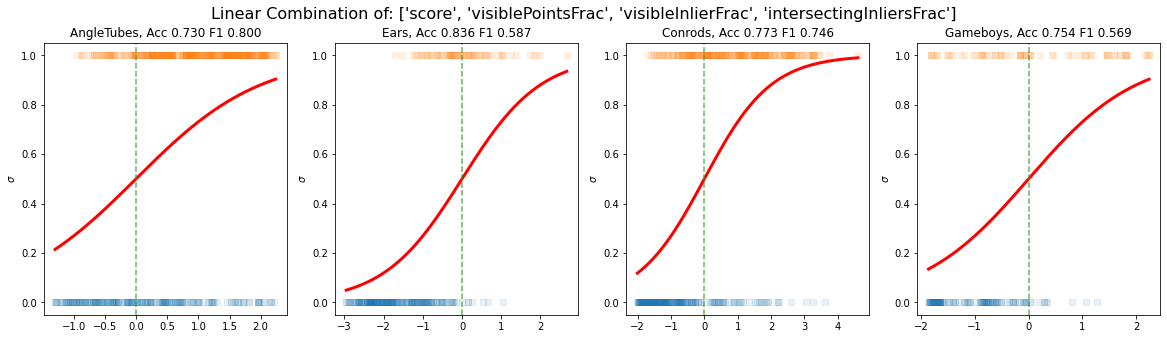

In [42]:
logistic_regression_plots(df,object_names = ["AngleTubes","Ears","Conrods","Gameboys"], factors= variables,normalize_factors=False)
plt.savefig("PrObjectLogisticRegressionWGlobalInfo.pdf")
plt.savefig("PrObjectLogisticRegressionWGlobalInfo.png")
plt.show()

In [43]:
df_m = df
df_m["intersectingInliersFracSelective"] =  (df["g"]*df["inCollisionInternal"]*df["intersectingInliersInternalFrac"]) + ((1-df["g"])*df["inCollisionExternal"]*df["intersectingInliersExternalFrac"]) 
df_m["penetrationSelective"] =  (df["g"]*df["inCollisionInternal"]*df["penetrationInternal"]) + ((1-df["g"])*df["inCollisionExternal"]*df["penetrationExternal"]) 

variables = ["score","visiblePointsFrac","visibleInlierFrac","penetrationSelective","intersectingInliersFracSelective"]
models, result_df = binary_logistic_regession(df_m,["AngleTubes","Ears","Conrods","Gameboys"],variables,normalize_factors=False)
result_df

/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/master/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jens/.virtualenvs/ma

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,penetrationSelective_w,intersectingInliersFracSelective_w,intercept
0,AngleTubes,0.730357,0.743842,0.865330,0.800000,349,211,0.071348,0.132870,0.348494,-0.021696,-0.159919,-2.178514
1,Ears,0.810219,0.756757,0.394366,0.518519,71,203,0.071975,2.144207,2.563909,-1.014259,-0.215882,-4.230711
2,Conrods,0.772917,0.784314,0.711111,0.745921,225,255,0.130434,-0.264129,1.872114,-0.125093,-1.354484,-3.165090
3,Gameboys,0.769634,0.815789,0.455882,0.584906,68,123,0.063330,-0.418495,-0.041950,-0.607381,-0.107995,-2.123950


In [44]:
df_m_coll = df[df["penetration"]>1]
df_m_coll["intersectingInliersFracSelective"] =  (df_m_coll["g"]*df_m_coll["inCollisionInternal"]*df_m_coll["intersectingInliersInternalFrac"]) + ((1-df_m_coll["g"])*df_m_coll["inCollisionExternal"]*df_m_coll["intersectingInliersExternalFrac"]) 
df_m_coll["penetrationSelective"] =  (df_m_coll["g"]*df_m_coll["inCollisionInternal"]*df_m_coll["penetrationInternal"]) + ((1-df_m_coll["g"])*df_m_coll["inCollisionExternal"]*df_m_coll["penetrationExternal"]) 

variables = ["score","visiblePointsFrac","visibleInlierFrac","penetrationSelective","intersectingInliersFracSelective"]
models, result_df = binary_logistic_regession(df_m_coll,["AngleTubes","Ears","Conrods","Gameboys"],variables,normalize_factors=False)
result_df

<ipython-input-44-80fa68d1fb9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m_coll["intersectingInliersFracSelective"] =  (df_m_coll["g"]*df_m_coll["inCollisionInternal"]*df_m_coll["intersectingInliersInternalFrac"]) + ((1-df_m_coll["g"])*df_m_coll["inCollisionExternal"]*df_m_coll["intersectingInliersExternalFrac"])
<ipython-input-44-80fa68d1fb9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m_coll["penetrationSelective"] =  (df_m_coll["g"]*df_m_coll["inCollisionInternal"]*df_m_coll["penetrat

,objName,accuracy,precision,recall,f1,n_posetives,n_negatives,score_w,visiblePointsFrac_w,visibleInlierFrac_w,penetrationSelective_w,intersectingInliersFracSelective_w,intercept
0,AngleTubes,0.796296,0.769231,0.937500,0.845070,32,22,0.058575,-0.189594,-0.145049,-0.289965,-0.134998,-1.264706
1,Ears,0.903226,0.000000,0.000000,0.000000,3,28,-0.005590,-0.000295,-0.000094,-0.000248,-0.000009,-0.702201
2,Conrods,0.841176,0.825000,0.622642,0.709677,53,117,0.104272,-0.020756,0.006618,-0.034823,-0.007116,-2.579339
3,Gameboys,0.860465,1.000000,0.250000,0.400000,8,35,0.021810,-0.379273,-0.146213,-0.315570,-0.049696,-1.204465


In [45]:
print_tuning_params(result_df,variables)

AngleTubes,LR,score_w,0.0585753727556532
AngleTubes,LR,visiblePointsFrac_w,-0.18959395911628746
AngleTubes,LR,visibleInlierFrac_w,-0.1450494279261968
AngleTubes,LR,penetrationSelective_w,-0.2899645687130008
AngleTubes,LR,intersectingInliersFracSelective_w,-0.13499814715102035
AngleTubes,LR,intercept,-1.2647064901284812
Ears,LR,score_w,-0.00558994224443893
Ears,LR,visiblePointsFrac_w,-0.0002952940633507728
Ears,LR,visibleInlierFrac_w,-9.441797530480808e-05
Ears,LR,penetrationSelective_w,-0.0002483362596084822
Ears,LR,intersectingInliersFracSelective_w,-9.065144628335884e-06
Ears,LR,intercept,-0.7022010561652334
Conrods,LR,score_w,0.10427163314768503
Conrods,LR,visiblePointsFrac_w,-0.0207555854882726
Conrods,LR,visibleInlierFrac_w,0.006618423865094362
Conrods,LR,penetrationSelective_w,-0.03482268327955422
Conrods,LR,intersectingInliersFracSelective_w,-0.007116330135111915
Conrods,LR,intercept,-2.579338544010518
Gameboys,LR,score_w,0.02180970335223073
Gameboys,LR,visiblePointsFrac_w,-0.37